In [ ]:
## installing relevant packages
# !pip install imbalanced-learn
# !pip install scikit-learn-extra
# !pip install factor_analyzer
# !pip install factor_analyzer
# !pip install --upgrade category_encoders

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##  importing relevant packaged
import re
import seaborn as sns
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
sns.set_style('white')
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
import factor_analyzer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn import cluster
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from datetime import datetime
from collections import Counter
from collections import defaultdict
from tqdm import tqdm
from random import choices
from sklearn.cluster import DBSCAN
from sklearn import cluster
from sklearn_extra.cluster import KMedoids
import category_encoders as ce

ModuleNotFoundError: ignored

In [ ]:
import os
os.chdir("/content/drive/Shareddrives/SIADS - 694-695 Team Drive")
!ls

## Read file and generating EDA

In [ ]:
## READ FILE AND GENERATING EDA
## columns to retrieve
keep=['socialEngagementType',
      'channelGrouping',
      'date',
      'fullVisitorId',
      'totals.hits',
      'totals.pageviews',
      'totals.timeOnSite',
      'totals.transactions',
      'totals.newVisits',
      'totals.totalTransactionRevenue',
      'hits.type',
      'geoNetwork.country',
      'trafficSource.source',
      'trafficSource.medium',
      'trafficSource.isTrueDirect',
      'device.browser',
       'device.operatingSystem',
      'device.deviceCategory',
      'hits.hour',
      'hits.minute',
      'totals.bounces',
      'hits.eCommerceAction.action_type']

In [ ]:
##  read file and only select 22 columns

df=pd.read_csv("datasets/final_file.csv").iloc[:,1:]
# df=pd.read_csv("datasets/processed_file.csv").iloc[:,1:]

if list(df.columns)!=keep:
    df=df[keep]
    df.to_csv("datasets/final_file.csv")

# remove unecessary columns that were unnested
try:
    df.drop(['geoNetwork','trafficSource',"device","totals","hits"], axis = 1,inplace=True)
except:
    pass


### OPTIONAL, create EDA TABLE and multilevel index (takes 2 minutes!)

In [ ]:
### OPTIONAL function that returns the features EDA - very userful for output data

def dimensions(df,download=True):
    
    if download:
        # exporting object to csv
        df_dim=pd.read_csv('datasets/dimensions.csv')
        print("download csv file")
        return df_dim

    
    
    # Creating EDA table and adding multilevel index to dimensions
    df_dim=df.iloc[0:1,].T
    # create major index
    idx=[x.split(".")[0] for x in list(df_dim.index)]
    df_dim.columns=["idx"]
    df_dim["idx"]=idx
    
    # # adding EDA columns
    cols=list(df.columns)
    df_dim["type"]=df.apply(lambda x:np.dtype(x),axis=0)
    df_dim["Unique_ct"]=df.apply(lambda x:len(x.unique()),axis=0)
    df_dim["ct_nan"]=df.apply(lambda x:x.isna().sum(),axis=0)

    ## adding key metrics
    df_dim["Counter"]=None
    df_dim["min"]=None
    df_dim["max"]=None
    df_dim["mean"]=None
    # df_dim["outlier_ct"]=None

    for element in list(df_dim.index):
        if df_dim.loc[element,"Unique_ct"]>1:   
        
            df_dim.at[element,"Counter"]=Counter(df[element]).most_common(5)
    
        if df_dim.loc[element,"type"]!="object":
            df_dim.at[element,"Counter"]=Counter(df[element]).most_common(5)
            
        try:    
            df_dim.at[element,"min"]=np.nanmin(df[element])
            df_dim.at[element,"max"]=np.nanmax(df[element])
            df_dim.at[element,"mean"]=np.nanmean(df[element])
        except:
            continue# df_dim.at[element,"outlier_ct"]=df[element].apply(lambda x:outliers(x,element))

    # calculating key metrics for dates
    try:
        df["date"]=df["date"].apply(lambda x:datetime.strptime(str(x),"%Y%m%d"))
        df_dim.at["date","min"]=np.min(df["date"]) # .apply(lambda x:datetime.strptime(str(x),"%Y%m%d")))
        df_dim.at["date","max"]=np.max(df["date"]) # .apply(lambda x:datetime.strptime(str(x),"%Y%m%d")))
        df_dim["spread"]=None
        df_dim.at["date","spread"]=df_dim.at["date","max"]-df_dim.at["date","min"]
    except:
        pass
    
    # try:
        # exporting object to csv
        # df_dim.to_csv('datasets/dimensions.csv')
       #  print("successful uploading to excel")
    # except:
        # print("failed to upload to excel, file is in use")
    
    return df_dim
# df_dim=dimensions(df,download=True)

### CONVERTING DATES TO DATETIME OBJECT

In [ ]:

## Converting dates to datetime object
def transform_date():
    try:
        df["date"]=df["date"].apply(lambda x:datetime.strptime(str(x),"%Y%m%d"))
        print(min(df["date"]),"succesfully transformed to a datime object")
    except:
        print("already a datime object")
        print(min(df["date"]))
transform_date()
    

2016-08-01 00:00:00 succesfully transformed to a datime object


### GENERATING RFM DIMENSIONS AND CLASSES

#### Convert transactions to real numbers (devide by 10^6) and create Monetary

Divided by 10^6
0.012


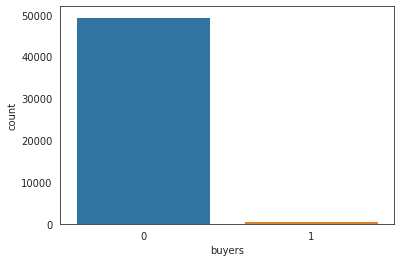

In [ ]:
## GENERATING RFM DIMENSIONS AND CLASSES

## Convert transactions to real numbers (devide by 10^6) and create Monetary
def transaction_conversion():
    maxi=np.nanmax(df['Monetary'])
    if maxi>20000:
        df['Monetary']=np.round((df['Monetary']/1000000),1)
        print("Divided by 10^6")
try:
    df["Monetary"]=df['totals.totalTransactionRevenue'].round(1)
    del(df['totals.totalTransactionRevenue'])
except:
    pass
transaction_conversion()

# generating buyers target class 0 did not buy, 1 bought. and 
# creating a class on monetarty checking class balance

if "buyers" not in list(df.columns):
    df["buyers"]=np.int64(df["Monetary"]>0)


print(round(len(df[df["buyers"]==1])/(len(df)),3))
# visualize the target variable
g = sns.countplot(df['buyers'])
g.set_xticklabels(['0','1'])
plt.show()

### ADDING RFM DIMENSIONS AND PREPARING DATASET

{0: 50074, 1: 32}
0.001


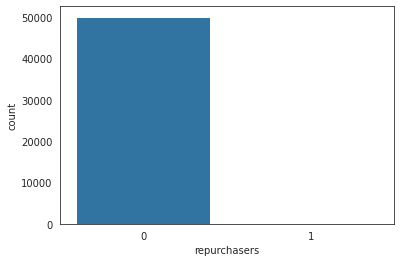

In [ ]:
### ADDING RFM DIMENSIONS AND PREPARING DATASET
# adding frequency of visits dimension
# Frequency is frequency of visit only not frequency of purchase!!!!

gb1=df.groupby("fullVisitorId").agg({"fullVisitorId":"size"}).rename(columns={"fullVisitorId":'count'}).reset_index()
dico=dict(zip(list(gb1["fullVisitorId"]),list(gb1["count"])))
df["Frequency"]=df["fullVisitorId"].apply(lambda x: dico[x])

# adding repurchasing class
gb=df[df["Monetary"]>0].groupby("fullVisitorId").agg({"buyers":"size"})
liste=gb[gb["buyers"]>1].index
df["repurchasers"]=df["fullVisitorId"].apply(lambda x: x in liste)
df["repurchasers"]=df["repurchasers"].astype(int)

print(dict(Counter(df["repurchasers"])))
print(round(len(df[df["repurchasers"]==1])/(len(df)),3))

# visualize the repurchase target variable
g = sns.countplot(df['repurchasers'])
g.set_xticklabels(['0','1'])
plt.show()


In [ ]:
# calculating recency, total spread - time since last visit in days.
try:
    # printing key date indicators
    maxi_date=np.max(df["date"])
    mini_date=np.min(df["date"])
    spread=(maxi_date-mini_date)
    print(maxi_date,mini_date,spread)
    df["Recency"]=(maxi_date-(pd.to_datetime(df["date"]))).dt.days
    df[["date","Recency"]].head(5)
except:
    print("transforming date to datime object")
    transform_date()

2017-01-31 00:00:00 2016-08-01 00:00:00 183 days 00:00:00


In [ ]:
# generating RFM with visitors also
rfm=df.groupby("fullVisitorId").agg({"Recency":"min", "Monetary":"sum", "Frequency":"min", "buyers":"max"})
## performing EDA
print(len(rfm))
print(rfm.describe().round(1))

## generating rfm_buyers 
rfm_buyers=rfm[rfm["buyers"]==1]
print(rfm_buyers.describe().round(1))

47867
       Recency  Monetary  Frequency   buyers
count  47867.0   47867.0    47867.0  47867.0
mean      91.6       2.0        1.0      0.0
std       48.9      51.6        0.3      0.1
min        0.0       0.0        1.0      0.0
25%       56.0       0.0        1.0      0.0
50%       89.0       0.0        1.0      0.0
75%      130.0       0.0        1.0      0.0
max      183.0    7003.5       18.0      1.0
       Recency  Monetary  Frequency  buyers
count    574.0     574.0      574.0   574.0
mean      91.1     169.0        1.3     1.0
std       52.7     440.9        0.8     0.0
min        0.0       2.0        1.0     1.0
25%       48.0      33.0        1.0     1.0
50%       85.0      60.8        1.0     1.0
75%      138.0     132.7        1.0     1.0
max      183.0    7003.5        8.0     1.0


# ENCODING CATEGORICAL VARIABLES

### convert hits.hour to integer, convert to 3 categories: 0:low, 1:medium, 2:peak hour

In [ ]:
# ENCODING CATEGORICAL VARIABLES

## Setting Date and fullvisitorID as indices
try:
    df.set_index(["date","fullVisitorId"],inplace=True)
except:
    pass

## defining categorical variable encoding
features={'socialEngagementType':["categorical","binary","int64","fillnan"], 
       'channelGrouping':["categorical","one_hot"],
          'date':["date","index"],
          'fullVisitorId':["int64","index"],
          'totals.hits':["int64"],
          'totals.pageviews':["float","fillnan"],
          'totals.timeOnSite':["float","fillnan"],
          'totals.transactions':["float","fillnan"],
          'totals.newVisits':["float","fillnan",'int64'],
          'hits.eCommerceAction.action_type':["int64"],
          'geoNetwork.country':["categorical","woe","buyers","drop"],
         'trafficSource.source':["categorical","woe","buyers","drop"],
          'trafficSource.medium':["categorical","one_hot"],
          'trafficSource.isTrueDirect':["categorical","fillnan","cat_code","int64"],
          'device.browser':["categorical","woe","buyers","drop"],
          'device.operatingSystem':["categorical","one_hot"],
          'device.deviceCategory':["categorical","one_hot"],
          'hits.type':["categorical","drop"],
          'hits.hour':["ordinal","ordinal_enc","drop"],
          'hits.minute':["date", "drop"],
          'totals.bounces':["float","fillnan","int64"],
          'Monetary':["float","fillnan"],
         'buyers':['boolean','class'],
          'Recency':['float'],
          "Frequency":["float"],
          'repurchasers':["boolean","class","int64"]
         }
feat=features


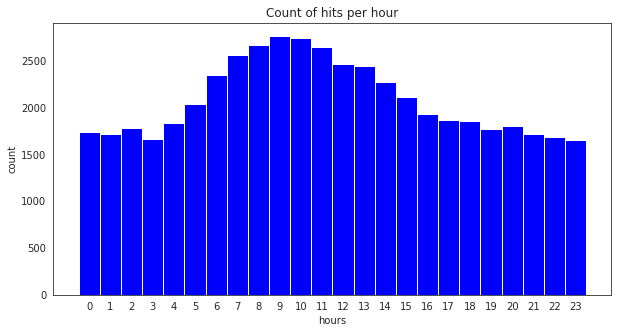

In [ ]:
## CONVERTING HITS HOURS TO ORDINAL WITH 3 CATEGORIES: LOW, MEDIUM, PEAK (0,1,2)
## extracting integer with regex
col="hits.hour"
pattern='\[([0-9]{1,2})'
df[col]=df[col].apply(lambda string: int(re.match(pattern,string).group(1)))
feat=features.copy()
df_copy=df.copy()
duo=dict(Counter(df_copy[col]))
duo=sorted(duo.items(), key=lambda pair: pair[0], reverse=False)
x=[str(x[0]) for x in duo]
y=[int(x[1]) for x in duo]


# creating the dataset
 
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
# ax1 = sns.barplot(x=x,y="count", hue="hits.hour_ordinal",dodge=False)
plt.bar(x, y, color ='blue',width = 1)
plt.xlabel("hours")
plt.ylabel("count")
plt.title("Count of hits per hour")
plt.show()

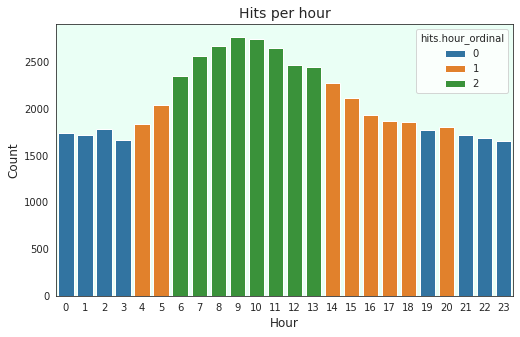

In [ ]:
# ordinal encoding with q categories
n=3
gb=df_copy.groupby(["hits.hour"]).agg({"hits.hour":"size"}).rename(columns={"hits.hour":'count'})
gb["hits.hour_ordinal"]=pd.qcut(gb["count"],q=n)
liste=sorted(list(gb["hits.hour_ordinal"].unique()))
new_features={}
for i in range(0,n):
    gb["hits.hour_ordinal"].replace({liste[i]: i},inplace=True)
    new_features[liste[i]]=i
features["hits.hour"].append(new_features)
    # , liste[1]: 1, liste[2]: 2})
    
dict_hours=dict(zip(gb.index, gb["hits.hour_ordinal"]))

# creating ordinal category in new column
df_copy["hits.hour_ordinal"]=df_copy["hits.hour"].apply(lambda k: dict_hours[k])
df_copy["hits.hour_ordinal"].head()

# visualizing data
data=gb

fig = plt.figure()
fig.set_size_inches(18, 5)
x=[str(x[0]) for x in duo]
y=[int(x[1]) for x in duo]

ax1 = plt.subplot(121)

ax1 = sns.barplot(data=data, x=x,y="count", hue="hits.hour_ordinal",dodge=False)

ax1.set_xlabel("Hour",fontsize=12)
ax1.set_ylabel("Count",fontsize=12)
ax1.set_title("Hits per hour",fontsize=14)
ax1.set_facecolor('#eafff5')

In [ ]:
### types of categories:
# onehot
# ordinal
# cat code or label encoding
# woe weight of evidence (based on the proportion of a category vis a vis a target class, for example buyers)

In [ ]:
# https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd#:~:text=Fore%20on%20Unsplash-,Categorical%20encoding%20using%20Label-Encoding%20and%20One-Hot-Encoder,orange%2C%20blue%2C%20white%20etc.
# CAT CODE OR label encoding

# methods available
# target: value of the target classifier
# target_mean: mean of the value of the target
# counter: counter of the class
# # backward difference coding
# reference: https://stats.oarc.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/#backward
# https://pbpython.com/categorical-encoding.html



# In the supervised ratio algorithm . 
# https://pkghosh.wordpress.com/2017/10/09/combating-high-cardinality-features-in-supervised-machine-learning/
# vi = pi / ti     where
# vi = numerical value for ith value of some categorical attribute
# pi = number of records with positive class value for the categorical attribute value in question
# ti = total number of records with the categorical attribute value in question

# In the weight of evidence algorithm (WOE)
# vi = log((pi / p) / (ni / n)    where
# pi = number of records with positive class value for the categorical attribute value in question
# ni = number of records with negative class value for the categorical attribute value in question
# p = total number of records with positive class value
# n = total number of records with negative class value

# separating numeric form categorical features


In [ ]:

def categorical_transfo(df_copy,col,method,i,dropped_features):
    changes=False
    if 'fillnan' in method:
        print(i, col, "fillnan")
        df_copy[col].fillna(0,inplace=True)
        changes=True
    
    if "scikitlearn_encoder" in method:
        print(i, col, "scikit_learn encoder")
        encoder = ce.BackwardDifferenceEncoder(cols=col)
        pd.concat([df_copy],[encoder.fit_transform(df_copy[col], verbose=1)])
        changes=True
            
    if "cat_code" in method:
        print("cat_code",col)
        df_copy[col+"_code"]=df_copy[col].astype('category').cat.codes
        dico={}
        dico={k:v for k,v in zip(list(df_copy[col]),list(df_copy[col+"_code"]))}
        del(df_copy[col])
        features[col].append(dico)
        
    if "counter" in method:
        print(i,col, "counter")
        dico=dict(Counter(df_copy[col]))
        df_copy[col+"_counter"]=df_copy[col].apply(lambda x: dico[x])
        changes=True
        
    # binary encoding    
    if "binary" in method:
        print(i,col, "binary")
        values=list(df_copy[col].unique())
        df_copy[col].replace(values[0], 0,inplace=True)
        if len(values)==2:
            df_copy[col].replace(values[1],1,inplace=True)
        changes=True
        
    # one-hot encoding 
    if "one_hot" in method:    
        data=pd.get_dummies(df_copy[col], prefix=col, prefix_sep='_',drop_first=True)
        dico={}
        dico[col]=list(data.columns)
        df_copy=pd.concat([df_copy,data],axis=1)
        features[col].append(dico)
        dropped_features.append(col)
        changes=True
        try:
            del(df_copy[col])
        except:
            pass
        print(i, col, "one_hot", "drop") 
        
    # weight of evidence method   
    if "woe" in method:
        target="buyers"
        gb=df_copy.groupby(by=[col,target]).agg({col:'size'})
        gb=gb.unstack()
        # pi = number of records with positive class value for the categorical attribute value in question
        # ni = number of records with negative class value for the categorical attribute value in question 
        gb.columns=["ni","pi"]
        # p = total number of records with positive class value
        p=len(df_copy[df_copy[target]==1])
         # n = total number of records with negative class value
        n=len(df_copy[df_copy[target]==0])
        # if pi==0 apply mean (avge conversion rate)
        avge=p/n
        print(avge)
        gb["pi"]=gb.apply(lambda x: x["ni"]*avge if pd.isna(x["pi"]) else x["pi"],axis=1)
        # vi = np.log((pi / p) / (ni / n))
        gb["vi"] = np.log((gb["pi"] / p) / (gb["ni"] / n))
        gb.sort_values("vi",ascending=False).head(10)
        dico=dict(zip(gb.index, gb.vi))

        df_copy[col+"_woe"]=df_copy[col].apply(lambda k: dico[k])
        df_copy[[col,col+"_woe"]]
        print(i,col,col+"_woe","woe")
        changes=True
    
    if "int64" in method:
        try:            
            df_copy[col]=df_copy[col].astype(int)
            print(i,col,"int64")
        except:
            pass
    
    if "drop" in method:
        try:
            del(df_copy[col])
            print(i,col,"drop")
            changes=True
            # returns list with dropped columns
            dropped_features.append(col)
        except:
            pass
        
    if not changes:
        print(i, col, "NO CHANGE")
    
    # returns new data frame and old_features
    return df_copy, dropped_features

liste_new_features=[]
changes_made1={}

i=0
print("Transformations being made")
dropped_features=[]

# returning df_copy with changes made and dropped_df with dropped features
for col,method in features.items():
    i+=1
    df_copy, dropped_features=categorical_transfo(df_copy,col, method,i,dropped_features)

# returning df with dropped features
dropped_df=df[dropped_features]

# returning all changes made in a single data frame
changes_made=dimensions(df_copy,download=False)

Transformations being made
1 socialEngagementType fillnan
1 socialEngagementType binary
1 socialEngagementType int64
2 channelGrouping one_hot drop
3 date NO CHANGE
4 fullVisitorId NO CHANGE
5 totals.hits int64
5 totals.hits NO CHANGE
6 totals.pageviews fillnan
7 totals.timeOnSite fillnan
8 totals.transactions fillnan
9 totals.newVisits fillnan
9 totals.newVisits int64
10 hits.eCommerceAction.action_type int64
10 hits.eCommerceAction.action_type NO CHANGE
0.011813170170230812
11 geoNetwork.country geoNetwork.country_woe woe
11 geoNetwork.country drop
0.011813170170230812
12 trafficSource.source trafficSource.source_woe woe
12 trafficSource.source drop
13 trafficSource.medium one_hot drop
14 trafficSource.isTrueDirect fillnan
cat_code trafficSource.isTrueDirect
0.011813170170230812
15 device.browser device.browser_woe woe
15 device.browser drop
16 device.operatingSystem one_hot drop
17 device.deviceCategory one_hot drop
18 hits.type drop
19 hits.hour drop
20 hits.minute drop
21 totals.b

### MANAGING CLASS IMBALANCE

In [ ]:
# MANAGING CLASS IMBALANCE - OPTIONAL
# Synthetic Minority Oversampling Technique (SMOTE)
# code reference https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/#:~:text=One%20way%20to%20fight%20imbalance,of%20the%20currently%20available%20samples.
# alternative
# During training, we can use the argument class_weight=’balanced’ to penalize 
# mistakes on the minority class by an amount proportional 
# to how under-represented it is.

def class_rebalance(df, targetclass):

    cols=list(df.columns)
    cols.remove(targetclass)

    
    # current class balance (0-visitors, 1-buyers)
    g = sns.countplot(df[targetclass])
    g.set_xticklabels(['0','1'])
    plt.show()
    
    ## set predictor x 
    x=df[cols]
    ## set y target
    y=df[targetclass]
    
    # rebalance
    smote = SMOTE()
    # fit predictor and target variable
    x_smote, y_smote = smote.fit_resample(x, y)
    print('Original dataset shape', Counter(y))
    print('Resample dataset shape', Counter(y_smote))
    
    # revisiting class balance
    g = sns.countplot(y_smote)
    g.set_xticklabels(['0','1'])
    plt.show()
    
    rebalanced_df=pd.concat([x_smote, y_smote], axis=1)
    
    return rebalanced_df
# rebalanced_buyers=class_rebalance(rfm, targetclass="buyers")
# print("new length", len(rebalanced_buyers))
# rebalanced_buyers.head()

# rebalanced_repurchasers=class_rebalance(df_copy, targetclass="repurchasers")
# print("new length", len(rebalanced_repurchasers))
# rebalanced_repurchasers.head()

## EXPORTING OUTPUT FILES

### changes_made.csv


#### Returning a data set with all changes made to dimensions

In [ ]:
### EXPORTING OUTPUT FILES

# 1- Exporting data set with all changes made to dimensions
try:
    changes_made.to_csv("datasets/changes_made.csv")
    print("succesfully exporting changes file to csv")
except:
    print("failed to export, file may be in use")
    
# 2- exporting A1_B2_data.csv (classification buyers and clustering visitors)
try:
    df_copy.to_csv("datasets/A1_B2_data.csv")
    dropped_df.to_csv("datasets/A1_B2_data_dropped_features.csv")
    print("succesfully exporting both A1_B2 files to csv")
except:
    print("failed to export, file may be in use")   
 
# 3- A2_return_data.csv - Returning customers dataset
df_buyers=df_copy[df_copy["Monetary"]>0]
try:
    df_buyers.to_csv("datasets/A2_return_data.csv")
    print("succesfully exporting A2 to csv")
except:
    print("failed to export, file may be in use")

# 4- B1_rfm_data.csv - RFM clustering data set
try:
    rfm.to_csv("datasets/B1_rfm_data.csv")
    print("succesfully exporting B1 rfm to csv")
except:
    print("failed to export, file may be in use")   
    
    

succesfully exporting changes file to csv
succesfully exporting both A1_B2 files to csv
succesfully exporting A2 to csv
succesfully exporting B1 rfm to csv


In [ ]:

 

# return split data sets
def split_train_set(rfm_sampled):
    train_df, cv_df, test_df = np.split(rfm_sampled.sample(frac=1, random_state=655),[int(.8*len(rfm_sampled)), int(.9*len(rfm_sampled))])
    x_train=train_df[["Recency", "Frequency"]]
    x_cv=cv_df[["Recency", "Frequency"]]
    x_test=test_df[["Recency", "Frequency"]]

    y_train=list(train_df["class"])
    y_cv=list(cv_df["class"])
    y_test=list(test_df["class"])
    
    print(len(y_train),len(y_cv),len(y_test))
    
    return train_df, cv_df, test_df
    

    
